# Introduction

If you ever had to do a literature search for a project, you probably could appreciate the great effort behind traversing the ever-expanding volumes of texts and trying to organize the extracted information. Throughout the last decades, some noticeable progress was made in using AI to automize the process. The modern machine learning approaches aim to identify, extract and store important information from unstructured texts. To make the extracted metadata active and FAIR, one often stores it in the form of a knowledge graph.

The pipeline for information extraction could be seen as a path of several steps:

- Collecting the text data
- Avoiding ambiguity of entities with coreference resolution
- Entity recognition and named entity linking
- Relationship extraction
- Storing the data as a knowledge graph

## Collecting the text data

First, one collects the text to extract the data from. Text may be the collection of internal documents, articles, online content, or the result of picture descriptions produced by image-to-text algorithms.

Here as an example, we will collect a dataset of articles' abstracts on the topic "cardiac amyloidosis". In the biological domain, articles can be collected from the PubMed database using biopython, for the sake of simplicity we will only go through the first 20 articles that come up in the search.




In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 31.7 MB/s 


In [ ]:
#importing libraries
from Bio import Entrez

def search(query, max_papers=20):
    """
    Get IDs of papers on the given topic from the pubmed database.
    """
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax=max_papers,
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results
    
def fetch_details(id_list):
    """
    Get details on each paper (including the abstract).
    """
    ids = ','.join(id_list)
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results
    
results = search('cardiac amyloidosis')
id_list = results['IdList']
papers = fetch_details(id_list)

/usr/local/lib/python3.7/dist-packages/Bio/Entrez/__init__.py:698: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  UserWarning,


## Avoiding ambiguity of entities with coreference resolution
The prepared text should go through the coreference resolution model. In a nutshell, this process should replace all ambiguous words in a sentence so that the text doesn’t need any extra context to be understood. For example, personal pronounsare being replaced with a referred person’s name. Athough there is a number of approaches to do that, one of the most recently developed is [crosslingual coreference](https://spacy.io/universe/project/crosslingualcoreference) from the spaCy universe. spaCy is a python library that provides an easy way to create pipelines for natural language processing. 

In [ ]:
!pip install crosslingual-coreference==0.2.3 spacy-transformers==1.1.5 wikipedia neo4j
!pip install --upgrade google-cloud-storage
!pip install transformers==4.18.0
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 93 kB/s 
     |████████████████████████████████| 174 kB 58.7 MB/s 
     |████████████████████████████████| 730 kB 35.2 MB/s 
     |████████████████████████████████| 2.9 MB 62.7 MB/s 
     |████████████████████████████████| 23.2 MB 78.3 MB/s 
     |████████████████████████████████| 464 kB 10.6 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x38e98000 @  0x7fc2ef98a615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 2.2 kB/s 
     |████████████████████████████████| 1.1 MB 71.1 MB/s 
     |██████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 35.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.17.0
    Uninstalling transformers-4.17.0:
      Successfully uninstalled transformers-4.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.1.5 requires transformers<4.18.0,>=3.4.0, but you have transformers 4.18.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12

In [ ]:
import spacy
import crosslingual_coreference

DEVICE = -1 # Number of the GPU, -1 if want to use CPU

# Add coreference resolution model
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": DEVICE})

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and are newly initiali

## Entity recognition and named entity linking
Nest step is named entity recognition. Here we want to extract all important entities from the sentences. Depending on a use case, one can train a model to recognize entities of a specific type. For example, in [this tutorial](https://towardsdatascience.com/clinical-named-entity-recognition-using-spacy-5ae9c002e86f) you can find a way to train a model to recognize some entities from a biomedical domain. However, the spaCy universe also provides some pre-trained models to recognize entities, which we are going to use in our example.
Then one intends to standardize the entities and map them to an existing ontology. The process is known as entity linking. Here we map entities from the text to corresponding unique ids from a target knowledge base, for example, Wikipedia. One can also use some databases, relevant to the specific topic of the texts. While mapping to the Wikipedia terms is performed in [this tutorial] (https://towardsdatascience.com/extract-knowledge-from-text-end-to-end-information-extraction-pipeline-with-spacy-and-neo4j-502b2b1e0754), we will try to map our entities to the [NCI Thesarius](https://bioportal.bioontology.org/ontologies/NCIT), for simplicity choosing the first match as a mapping. Note, that in principle that is not always the best choice and one can use different similarity metrics to identify the best matching term in the ontology. 

## Relationship Extraction
After entity linking to get standard trios (object, relation, subject) for a knowledge graph, we extract the relationships between the identified entities. 
The [Rebel project](https://github.com/Babelscape/rebel), which is also available as a spaCy component, allows us to extract both entities and relations in one step, which we can use in our pipeline. 

To implement our approach of linking the entities to NCIT, we can rewrite the set_annotations function from rebel as specified [here](https://towardsdatascience.com/extract-knowledge-from-text-end-to-end-information-extraction-pipeline-with-spacy-and-neo4j-502b2b1e0754) and turn call_wiki_api function into call_ncit function

In [ ]:
# Add rebel component https://github.com/Babelscape/rebel/blob/main/spacy_component.py
import requests
import re
import hashlib
from spacy import Language
from typing import List
import pandas as pd

from spacy.tokens import Doc, Span

from transformers import pipeline

def call_ncit_api(item):
  try:
    url = f"https://www.ebi.ac.uk/ols/api/search?q={item}&ontology=ncit"
    data = pd.DataFrame(requests.get(url).json().get('response').get('docs'))
    # Return the first id (A simplistic non-perfect way for mapping)
    return data["label"][0]
  except:
    return 'id-less'

def extract_triplets(text):
    """
    Function to parse the generated text and extract the triplets
    """
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})

    return triplets


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)
        self.entity_mapping = {}
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
          Doc.set_extension("rel", default={})

    def get_wiki_id(self, item: str):
        #mapping = self.entity_mapping.get(item)
        #if mapping:
        #  return mapping
        #else:
        res = call_ncit_api(item)
        self.entity_mapping[item] = res
        return res

    
    def _generate_triplets(self, sent: Span) -> List[dict]:
          output_ids = self.triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]["output_ids"]
          extracted_text = self.triplet_extractor.tokenizer.batch_decode(output_ids[0])
          extracted_triplets = extract_triplets(extracted_text[0])
          return extracted_triplets

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        for triplet in triplets:

            # Remove self-loops (relationships that start and end at the entity)
            if triplet['head'] == triplet['tail']:
                continue

            # Use regex to search for entities
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)

            # Skip the relation if both head and tail entities are not present in the text
            # Sometimes the Rebel model hallucinates some entities
            if not head_span or not tail_span:
              continue

            index = hashlib.sha1("".join([triplet['head'], triplet['tail'], triplet['type']]).encode('utf-8')).hexdigest()
            if index not in doc._.rel:
                # Get wiki ids and store results
                doc._.rel[index] = {"relation": triplet["type"], "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(triplet['tail'])}}

    def __call__(self, doc: Doc) -> Doc:
        for sent in doc.sents:
            sentence_triplets = self._generate_triplets(sent)
            self.set_annotations(doc, sentence_triplets)
        return doc

After redefining the Rebel spaCy component, we include it into our pipeline:

In [ ]:
DEVICE = -1 # Number of the GPU, -1 if want to use CPU

# Add coreference resolution model
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": DEVICE})

# Define rel extraction model
rel_ext = spacy.load('en_core_web_sm', disable=['ner', 'lemmatizer', 'attribute_rules', 'tagger'])
rel_ext.add_pipe("rebel", config={
    'device':DEVICE, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )

/usr/local/lib/python3.7/dist-packages/allennlp/models/archival.py:328: UserWarning: The model models/crosslingual-coreference/minilm/model.tar.gz was trained on a newer version of AllenNLP (v2.9.3), but you're using version 2.10.1.
  UserWarning,


Now we can text the pipeline on two simple sentences:

In [ ]:
input_text = "High fever is very dangerous. It can be treated with paracetamol."

coref_text = coref(input_text)._.resolved_text
print(coref_text)

doc = rel_ext(coref_text)

for value, rel_dict in doc._.rel.items():
    print(f"{value}: {rel_dict}")

#output:
#0440ea848947d2677bc11443f99f20f67ce0a1bc: {'relation': 'subclass of', 'head_span': {'text': 'High fever', 'id': 'High Grade Fever'}, 'tail_span': {'text': 'dangerous', 'id': 'DRRI-2 - A: Dangerous Military Duties'}}
#8aa25d264897bd007d389890b2239c2b9c07fa0b: {'relation': 'drug used for treatment', 'head_span': {'text': 'High fever', 'id': 'High Grade Fever'}, 'tail_span': {'text': 'paracetamol', 'id': 'Acetaminophen Measurement'}}
#d91bef9bfc94439523675b5d6a62e1f4635c0cdd: {'relation': 'medical condition treated', 'head_span': {'text': 'paracetamol', 'id': 'Acetaminophen Measurement'}, 'tail_span': {'text': 'High fever', 'id': 'High Grade Fever'}}

0440ea848947d2677bc11443f99f20f67ce0a1bc: {'relation': 'subclass of', 'head_span': {'text': 'High fever', 'id': 'High Grade Fever'}, 'tail_span': {'text': 'dangerous', 'id': 'DRRI-2 - A: Dangerous Military Duties'}}
8aa25d264897bd007d389890b2239c2b9c07fa0b: {'relation': 'drug used for treatment', 'head_span': {'text': 'High fever', 'id': 'High Grade Fever'}, 'tail_span': {'text': 'paracetamol', 'id': 'Acetaminophen Measurement'}}
d91bef9bfc94439523675b5d6a62e1f4635c0cdd: {'relation': 'medical condition treated', 'head_span': {'text': 'paracetamol', 'id': 'Acetaminophen Measurement'}, 'tail_span': {'text': 'High fever', 'id': 'High Grade Fever'}}


In [ ]:
coref_text

'High fever is very dangerous. High fever can be treated with paracetamol.'

You can see, that on the coreference step the "it" pronoun in the second sentance was replaced by the unambiguous "High fever" entity. 
After that the rebel model has extracted the trios of subject, relation and object and mapped them to the NCIT model. Note, that the mapping here is far from perfect. For example, the entity 'dangerous' was mapped to the 'DRRI-2 - A: Dangerous Military Duties' in NCIT. this is because in our mapping procedure for simplisity we have chosen the first result for the term in the NCIT database. To improve this, one would need to develop a more complex mapping algorithm.



## Storing the results

The final subject, relation, and object trios can be stored as either a labeled property graph or as an RDF graph. The guidelines to store the results as a neo4j labeled property graph are given [here](https://towardsdatascience.com/extract-knowledge-from-text-end-to-end-information-extraction-pipeline-with-spacy-and-neo4j-502b2b1e0754). Here we will give an approach to store the results as an RDF graph by using rdflib library in python.

Rdflib allows the creation of entities with known URIs with the URIRef command. Also, one can create a custom namespace with new entities and relations. 

In [ ]:
!pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 24.3 MB/s 
     |████████████████████████████████| 41 kB 463 kB/s 


In [ ]:
from rdflib import Graph
from rdflib import URIRef, BNode, Literal, Namespace
import json

def Capitalise_underscore(relation):
  return relation.capitalize().replace(' ','_')

def ncit_iri(item):
  try:
    url = f"https://www.ebi.ac.uk/ols/api/search?q={item}&ontology=ncit"
    data = pd.DataFrame(requests.get(url).json().get('response').get('docs'))
    # Return the first id
    return data["iri"][0]
  except:
    return 'id-less'

g=Graph()
EX = Namespace('http://example.org./')

relations = pd.DataFrame()


results = search('cardiac amyloidosis')
id_list = results['IdList']
papers = fetch_details(id_list)
for i, paper in enumerate(papers['PubmedArticle']):
    print("{}) {}".format(i+1, paper['MedlineCitation']['Article']['ArticleTitle']))
    
    abstract_text_json = json.dumps(papers['PubmedArticle'][i]['MedlineCitation']['Article']['Abstract']['AbstractText'])
    abstract_text = ' '.join(json.loads(abstract_text_json))
    print(abstract_text)
    coref_text = coref(abstract_text)._.resolved_text
    doc = rel_ext(coref_text)
    for value, rel_dict in doc._.rel.items():
      subject_iri = ncit_iri(rel_dict['head_span']['text'])
      object_iri = ncit_iri(rel_dict['head_span']['text'])
      if subject_iri != 'id=less':
        subj = URIRef(subject_iri)
      else:
        subj = EX[rel_dict['head_span']['text']]
      if object_iri != 'id=less':
        obj = URIRef(object_iri)
      else:
        subj = EX[rel_dict['head_span']['text']]  
      pred = EX[Capitalise_underscore(rel_dict['relation'])]
      g.add((subj, pred, obj))        
    df = pd.DataFrame.from_dict(doc._.rel).transpose()
    df['subject_text'] = df.head_span.apply(lambda x: x['text'])
    df['subject_id'] = df.head_span.apply(lambda x: x['id'])
    df['object_text'] = df.tail_span.apply(lambda x: x['text'])
    df['object_id'] = df.tail_span.apply(lambda x: x['id'])

    df = df.drop(["head_span", "tail_span"], axis = 1)

    relations = pd.concat([relations, df])


/usr/local/lib/python3.7/dist-packages/Bio/Entrez/__init__.py:698: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  UserWarning,


1) Clinical Outcomes and Effectiveness of Heart Transplantation in Patients With Systemic Light-chain Cardiac Amyloidosis.
In systemic light-chain (AL) amyloidosis, cardiac involvement is a major determinant of survival; however, cardiac response is limited even after systemic treatment in a majority of patients, and some require heart transplantation. Additionally, limited information is available on specific indications for heart transplantation. We aimed to explore clinical outcomes of cardiac amyloidosis and its association with heart transplantation, including identifying factors favoring heart transplantation amenability. We retrospectively analyzed data from patients diagnosed with AL amyloidosis with cardiac involvement between January 2007 and December 2020 at a tertiary referral center. Among 73 patients, 72 (99%) received systemic treatment, and 12 (16%) underwent heart transplantation. Characteristics at diagnosis were similar between heart transplant recipients and nonreci

/usr/local/lib/python3.7/dist-packages/allennlp/modules/token_embedders/pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


4) Indexed left ventricular mass to QRS voltage ratio is associated with heart failure hospitalizations in patients with cardiac amyloidosis.
In cardiac amyloidosis (CA), amyloid infiltration results in increased left ventricular (LV) mass disproportionate to electrocardiographic (EKG) voltage. We assessed the relationship between LV mass-voltage ratio with subsequent heart failure hospitalization (HHF) and mortality in CA. Patients with confirmed CA and comprehensive cardiovascular magnetic resonance (CMR) and EKG exams were included. CMR-derived LV mass was indexed to body surface area. EKG voltage was assessed using Sokolow, Cornell, and Limb-voltage criteria. The optimal LV mass-voltage ratio for predicting outcomes was determined using receiver operating characteristic curve analysis. The relationship between LV mass-voltage ratio and HHF was assessed using Cox proportional hazards analysis adjusting for significant covariates. A total of 85 patients (mean 69 ± 11 years, 22% femal

Finally, we can visualize the resulting graph and export it in .ttl format.

In [ ]:
print(g.serialize(format = 'ttl'))

@prefix ns1: <http://example.org./> .

<http://purl.obolibrary.org/obo/NCIT_C101233> ns1:Studied_by <http://purl.obolibrary.org/obo/NCIT_C101233> .

<http://purl.obolibrary.org/obo/NCIT_C101234> ns1:Subclass_of <http://purl.obolibrary.org/obo/NCIT_C101234> .

<http://purl.obolibrary.org/obo/NCIT_C102315> ns1:Subclass_of <http://purl.obolibrary.org/obo/NCIT_C102315> .

<http://purl.obolibrary.org/obo/NCIT_C109879> ns1:Subject_has_role <http://purl.obolibrary.org/obo/NCIT_C109879> .

<http://purl.obolibrary.org/obo/NCIT_C110970> ns1:Inception <http://purl.obolibrary.org/obo/NCIT_C110970> .

<http://purl.obolibrary.org/obo/NCIT_C111330> ns1:Has_cause <http://purl.obolibrary.org/obo/NCIT_C111330> .

<http://purl.obolibrary.org/obo/NCIT_C111860> ns1:Instance_of <http://purl.obolibrary.org/obo/NCIT_C111860> .

<http://purl.obolibrary.org/obo/NCIT_C113808> ns1:Subclass_of <http://purl.obolibrary.org/obo/NCIT_C113808> .

<http://purl.obolibrary.org/obo/NCIT_C114167> ns1:Studies <http://purl.ob

Visualization of the graph:

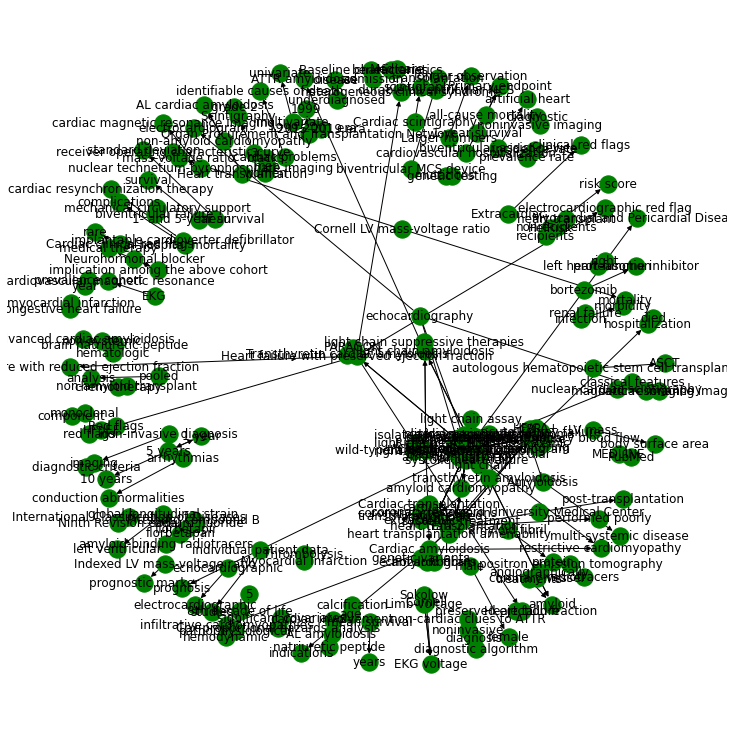

In [ ]:
import networkx as ntx
import matplotlib.pyplot as plot

graph = ntx.from_pandas_edgelist(relations, "subject_text", "object_text", edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(10, 10))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()